In [ ]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.read_csv('NBA_PBP_2015-16.csv')
df.head()  #


FileNotFoundError: [Errno 2] No such file or directory: 'NBA_PBP_2015-16.csv'

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


nba play to play verilerini 2015-2021 arası ayrı dosyalanmıs birlestirip tek bir dataframe olusturalım.

In [4]:
import pandas as pd
import os

# Dosya yolun
data_folder = '/content/drive/MyDrive/nba_data'

# Klasördeki CSV dosyalarını listele
csv_files = [f for f in os.listdir(data_folder) if f.startswith('NBA_PBP_') and f.endswith('.csv')]

df_list = []

for file in sorted(csv_files):
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    season = file.replace('NBA_PBP_', '').replace('.csv', '')
    df['Season'] = season
    df_list.append(df)

# Tümünü birleştir
combined_df = pd.concat(df_list, ignore_index=True)

print("Birleştirilen veri seti satır sayısı:", combined_df.shape[0])
print(combined_df.head())


Birleştirilen veri seti satır sayısı: 3040524
                            URL GameType                       Location  \
0  /boxscores/201510270ATL.html  regular  Philips Arena Atlanta Georgia   
1  /boxscores/201510270ATL.html  regular  Philips Arena Atlanta Georgia   
2  /boxscores/201510270ATL.html  regular  Philips Arena Atlanta Georgia   
3  /boxscores/201510270ATL.html  regular  Philips Arena Atlanta Georgia   
4  /boxscores/201510270ATL.html  regular  Philips Arena Atlanta Georgia   

              Date     Time WinningTeam  Quarter  SecLeft AwayTeam  \
0  October 27 2015  8:00 PM         DET        1      720      DET   
1  October 27 2015  8:00 PM         DET        1      701      DET   
2  October 27 2015  8:00 PM         DET        1      699      DET   
3  October 27 2015  8:00 PM         DET        1      697      DET   
4  October 27 2015  8:00 PM         DET        1      681      DET   

                                            AwayPlay  ...  LeaveGame  \
0  Jump ba

In [5]:
print(combined_df.dtypes)



URL                    object
GameType               object
Location               object
Date                   object
Time                   object
WinningTeam            object
Quarter                 int64
SecLeft                 int64
AwayTeam               object
AwayPlay               object
AwayScore               int64
HomeTeam               object
HomePlay               object
HomeScore               int64
Shooter                object
ShotType               object
ShotOutcome            object
ShotDist              float64
Assister               object
Blocker                object
FoulType               object
Fouler                 object
Fouled                 object
Rebounder              object
ReboundType            object
ViolationPlayer        object
ViolationType          object
TimeoutTeam            object
FreeThrowShooter       object
FreeThrowOutcome       object
FreeThrowNum           object
EnterGame              object
LeaveGame              object
TurnoverPl

Elimdeki veriden savunma odaklı bir anliz yapacağım için ona uygun yeni bir dataframe olusturucam defense_df adıyla. Bu veri ile oyuncuların yaptıgı  blokların(mesafesine göre), yapılan top çalmalar, bloklar ve faullerle ilgili bize vericek. Elimizdeki ham veriden sadece blok mesafesine erişebiliyoruz. Defense_df olusturduktan sonra dbscan ile kümeleyerek amacım -1(white noise) oyuncuları bularak ligdeki en iyi savunmacıları bulmak.

Elimdeki veriden sadece bloklar için  mesafe bilgisine sahibim bu sebeple , blokları mesafeye göre ayırıp (feauture engineering) filtreleyip one hot encoding uygulayacam ve en iyi savunmacıları mesafeye göre analiz etmiş olucam.

In [6]:
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# ==========================================
# --- BLOCK ---
def categorize_distance(dist):
    if dist <= 5:
        return 'near'
    elif dist <= 15:
        return 'mid'
    else:
        return 'far'

blocks = combined_df[combined_df['Blocker'].notnull() & combined_df['ShotDist'].notnull()].copy()
blocks['BlockRange'] = blocks['ShotDist'].apply(categorize_distance)

block_ohe = blocks.groupby(['Blocker', 'BlockRange']).size().unstack(fill_value=0).reset_index()
block_ohe = block_ohe.rename(columns={'Blocker': 'Player'})

for col in ['near', 'mid', 'far']:
    if col in block_ohe.columns:
        block_ohe.rename(columns={col: f'block_{col}'}, inplace=True)

block_cols = [col for col in block_ohe.columns if col.startswith('block_')]
block_ohe['total_blocks'] = block_ohe[block_cols].sum(axis=1)

block_avg_dist = blocks.groupby('Blocker')['ShotDist'].mean().reset_index().rename(columns={'Blocker': 'Player', 'ShotDist': 'avg_block_dist'})

# ==========================================
# --- STEAL ---
steals = combined_df[combined_df['TurnoverCause'] == 'steal'].copy()

steal_counts = steals.groupby('TurnoverCauser').size().reset_index(name='total_steals')
steal_counts = steal_counts.rename(columns={'TurnoverCauser': 'Player'})

# ==========================================
# --- DEFENSIVE REBOUNDS ---
def_rebounds = combined_df[combined_df['ReboundType'] == 'defensive']
rebound_stats = def_rebounds.groupby('Rebounder').size().reset_index(name='total_def_rebounds').rename(columns={'Rebounder': 'Player'})

# ==========================================
# --- FOULS ---
fouls = combined_df[combined_df['Fouler'].notnull()].copy()

if 'FoulType' in fouls.columns:
    foul_ohe = fouls.groupby(['Fouler', 'FoulType']).size().unstack(fill_value=0).reset_index()
else:
    fouls['FoulType'] = 'defensive'  # fallback
    foul_ohe = fouls.groupby(['Fouler', 'FoulType']).size().unstack(fill_value=0).reset_index()

foul_ohe = foul_ohe.rename(columns={'Fouler': 'Player'})

for col in foul_ohe.columns:
    if col != 'Player':
        foul_ohe.rename(columns={col: f'foul_{col}'}, inplace=True)

foul_cols = [col for col in foul_ohe.columns if col.startswith('foul_')]
foul_ohe['total_fouls'] = foul_ohe[foul_cols].sum(axis=1)

# ==========================================
# --- Merge all defensive stats ---
dfs = [block_ohe, block_avg_dist, steal_counts, rebound_stats, foul_ohe]
defense_df = reduce(lambda left, right: pd.merge(left, right, on='Player', how='outer'), dfs).fillna(0)

# ==========================================
# --- Clustering ---
features = defense_df.drop(columns=['Player'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

dbscan = DBSCAN(eps=1.0, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)
defense_df['Cluster'] = clusters

valid_mask = clusters != -1
if valid_mask.sum() > 1 and len(np.unique(clusters[valid_mask])) > 1:
    silhouette = silhouette_score(X_scaled[valid_mask], clusters[valid_mask])
    print("Silhouette Score:", silhouette)
else:
    print("Silhouette score hesaplanamadı (tek küme ya da fazla noise olabilir).")

# Küme ortalamaları
print(defense_df.groupby('Cluster').mean(numeric_only=True))


Silhouette Score: 0.3780553610037032
         block_far  block_mid  block_near  total_blocks  avg_block_dist  \
Cluster                                                                   
-1        9.874459  23.045455   95.242424    128.162338        5.705638   
 0        0.444444   1.444444    7.888889      9.777778        4.570408   
 1        0.513986   1.498252    6.167832      8.180070        3.348571   
 2        1.200000   0.000000    0.000000      1.200000       26.100000   
 3        1.666667  10.333333   58.666667     70.666667        3.749661   
 4        1.000000   2.666667   12.000000     15.666667        3.949242   
 5        0.333333   3.000000   12.666667     16.000000        4.297314   
 6        0.666667   3.333333   11.666667     15.666667        4.001941   

         total_steals  total_def_rebounds  foul_away from play  \
Cluster                                                          
-1         201.095238          954.058442             1.112554   
 0          20

Silhoutte score 0.37 gelmesi yapılan kümelemenin cok da iyi bir ayrım yapamadıgını göösteriyor, 7 kümeye ayırmıs ve bütün average değerleri incelediğimizde -1 kümesi hariç diğer kümelerin bazı parametrelerde birbirine benzediğini  yani algoritmanın yetersiz parametre olması sebebiyle ayrım yapmada zorlandıgını görürüz ama algoritma yine de -1 yani white noise kümesini çok iyi ayırdı ki benim de amacım white noise içinde en iyi istatistiğe sahip oyuncuları bulup en iyi savunma oyuncularını bulmaktı.





Şimdi -1 kümesindeki oyuncuları en iyi spesifik istatistiklere göre sıralayarak belli bir alana göre en iyi oyuncuları sıralayalım.

In [7]:
# Eksik değerleri dolduralım
defense_df[['total_steals', 'avg_block_dist']] = defense_df[['total_steals', 'avg_block_dist']].fillna(0)

# Fonksiyon: her kümede verilen metriğe göre en yüksek oyuncuyu al
def top_players_by_stat(df, stat):
    return df.loc[df.groupby("Cluster")[stat].idxmax()][["Player", "Cluster", stat]].sort_values("Cluster")

# En iyi oyuncular
top_blockers = top_players_by_stat(defense_df, "total_blocks")
top_stealers = top_players_by_stat(defense_df, "total_steals")
top_rebounders = top_players_by_stat(defense_df, "total_def_rebounds")
top_foulers = top_players_by_stat(defense_df, "total_fouls")
top_dist_blockers = top_players_by_stat(defense_df, "avg_block_dist")

# Merge ile tabloyu birleştir
top_defenders = top_blockers.merge(top_stealers, on="Cluster", suffixes=("_blocks", "_steals"))
top_defenders = top_defenders.merge(top_rebounders, on="Cluster")
top_defenders = top_defenders.merge(top_foulers, on="Cluster", suffixes=("_rebounds", "_fouls"))
top_defenders = top_defenders.merge(top_dist_blockers, on="Cluster", suffixes=("", "_max_dist"))

# Anlamlı sütun adları
top_defenders = top_defenders.rename(columns={
    "Player_blocks": "Top Blocker",
    "total_blocks": "Blocks",
    "Player_steals": "Top Stealer",
    "total_steals": "Steals",
    "Player": "Top Rebounder",
    "total_def_rebounds": "Def Rebounds",
    "Player_fouls": "Top Fouler",
    "total_fouls": "Fouls",
    "Player_max_dist": "Longest Blocker",
    "avg_block_dist": "Avg Block Dist"
})

# Göster
print(top_defenders)


                Top Blocker  Cluster  Blocks               Top Stealer  \
0  H. Whiteside - whiteha01       -1   912.0     J. Harden - hardeja01   
1   O. Spellman - spellom01        0    49.0   O. Spellman - spellom01   
2        E. Udoh - udohek01        1   107.0   S. Harrison - harrish01   
3    A. Edwards - edwaran01        2     2.0    A. Edwards - edwaran01   
4     J. Withey - witheje01        3    89.0        B. Bass - bassbr01   
5    C. Johnson - johnsch04        4    20.0  J. McRoberts - mcrobjo01   
6    T. Wallace - wallaty01        5    21.0      T. Brown - browntr01   
7     R. Vaughn - vaughra01        6    29.0     R. Vaughn - vaughra01   

   Steals             Player_rebounds  Def Rebounds               Top Fouler  \
0   796.0                        Team       28517.0     D. Green - greendr01   
1    59.0     O. Spellman - spellom01         264.0    S. Milton - miltosh01   
2   151.0  J. Hernangómez - hernaju01         585.0     D. House - houseda01   
3     6.0    

In [8]:
print(defense_df[defense_df['Cluster'] == 1]['Player'].head(10))

5      A. Bargnani - bargnan01
7       A. Bennett - bennean01
12        A. Brown - brownan02
15    A. Cleveland - clevean01
16       A. Coffey - coffeam01
22      A. Gentry - gentral99c
23          A. Gill - gillan01
24      A. Goodwin - goodwar01
26    A. Goudelock - goudean01
27      A. Hammons - hammoaj01
Name: Player, dtype: object


In [9]:
print(defense_df[defense_df['Cluster'] == -1]['Player'].head(10))

0                - tmptmp01c
1     A. Afflalo - afflaar01
2      A. Ajinça - ajincal01
3       A. Aminu - aminual01
6      A. Baynes - baynear01
9       A. Bogut - bogutan01
10    A. Bradley - bradlav01
11     A. Brooks - brookaa01
13      A. Burks - burksal01
14     A. Caruso - carusal01
Name: Player, dtype: object


In [10]:
# Outlier oyuncular
outliers_df = defense_df[defense_df['Cluster'] == -1]

# En çok blok yapan 10 outlier oyuncu
top_blocks = outliers_df.sort_values(by='total_blocks', ascending=False).head(10)
print("En çok blok yapan outlier oyuncular:")
print(top_blocks[['Player', 'total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']])

# En çok top çalan 10 outlier oyuncu
top_steals = outliers_df.sort_values(by='total_steals', ascending=False).head(10)
print("\nEn çok top çalan outlier oyuncular:")
print(top_steals[['Player', 'total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']])

# En çok faul yapan 10 outlier oyuncu
top_fouls = outliers_df.sort_values(by='total_fouls', ascending=False).head(10)
print("\nEn çok faul yapan outlier oyuncular:")
print(top_fouls[['Player', 'total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']])


En çok blok yapan outlier oyuncular:
                           Player  total_blocks  avg_block_dist  total_steals  \
364      H. Whiteside - whiteha01         912.0        4.523026         222.0   
840         R. Gobert - goberru01         894.0        4.586130         289.0   
18           A. Davis - davisan02         841.0        6.164090         532.0   
741         M. Turner - turnemy01         815.0        3.354601         269.0   
100          B. Lopez - lopezbr01         753.0        3.965471         246.0   
893          S. Ibaka - ibakase01         627.0        3.443381         201.0   
330  G. Antetokounmpo - antetgi01         612.0        4.271242         550.0   
19        A. Drummond - drumman01         591.0        4.631134         631.0   
128         C. Capela - capelca01         581.0        3.437177         264.0   
242         D. Jordan - jordade01         548.0        4.098540         216.0   

     total_def_rebounds  total_fouls  
364              3238.0       10

Dbscan kümelemesi sonucunda analiz olarak Anthony Davis ve Antetoukompo nun en yüksek blok yapan oyuncular içindeki sıralamada top çalma sayılarının diğer blokçu oyyuncuların nerdeyse 2 katı olması bu oyuncuların çok özel savunmacılar belirtisi. Top çalması yüksek olan oyunculara gelirsek diğer istatistiklerine baktığımzda blok mesafelerinde Russel Westbrook çembere genel anlamda yakın blok yapıyor yani , savunma tercihinde atak yapan oyuncuyu turnikeye zorlayan ve orda bloklayan bir yapısı var. Diğer oyuncular ise genel anlamda orta mesafede blok yapmıslar, ve oyuncuları çembere yaklaştırmayan bir savunma anlayısları var. Bu oyuncular içinde chris paul,james harden ve marcus smart kısa oyuncular yani guard pozisyonunda oynayanlar. Buradan su çıkarımı rahatlıkla yapabiliriz, guardlar arasında bu oyuncular en iyi savunma yapanları. Ayrıca Drummond isimli pivot oyuncusunun her istatistikte ilk 10 da bulunması en agresif ve komple savunma oyuncularından biri oldugunu gösterir.

In [ ]:
# Outlier oyuncular
outliers_df = defense_df[defense_df['Cluster'] == -1]

# En çok blok yapan 10 outlier oyuncu
top_blocks = outliers_df.sort_values(by='total_blocks', ascending=False).head(10)
print("En çok blok yapan outlier oyuncular:")
print(top_blocks[['Player', 'total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']])

# En çok top çalan 10 outlier oyuncu
top_steals = outliers_df.sort_values(by='total_steals', ascending=False).head(10)
print("\nEn çok top çalan outlier oyuncular:")
print(top_steals[['Player', 'total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']])

# En çok faul yapan 10 outlier oyuncu
top_fouls = outliers_df.sort_values(by='total_fouls', ascending=False).head(10)
print("\nEn çok faul yapan outlier oyuncular:")
print(top_fouls[['Player', 'total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']])


En çok blok yapan outlier oyuncular:
                           Player  total_blocks  avg_block_dist  total_steals  \
364      H. Whiteside - whiteha01         912.0        4.523026         222.0   
840         R. Gobert - goberru01         894.0        4.586130         289.0   
18           A. Davis - davisan02         841.0        6.164090         532.0   
741         M. Turner - turnemy01         815.0        3.354601         269.0   
100          B. Lopez - lopezbr01         753.0        3.965471         246.0   
893          S. Ibaka - ibakase01         627.0        3.443381         201.0   
330  G. Antetokounmpo - antetgi01         612.0        4.271242         550.0   
19        A. Drummond - drumman01         591.0        4.631134         631.0   
128         C. Capela - capelca01         581.0        3.437177         264.0   
242         D. Jordan - jordade01         548.0        4.098540         216.0   

     total_def_rebounds  total_fouls  
364              3238.0       10

In [ ]:
cluster_1 = defense_df[defense_df['Cluster'] == 1]

# En çok blok yapan 10 oyuncu
top_blocks_1 = cluster_1.sort_values('total_blocks', ascending=False).head(10)
print("Cluster 1 - En çok blok yapan oyuncular:")
print(top_blocks_1[['Player', 'total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']])

# En çok top çalan 10 oyuncu
top_steals_1 = cluster_1.sort_values('total_steals', ascending=False).head(10)
print("\nCluster 1 - En çok top çalan oyuncular:")
print(top_steals_1[['Player', 'total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']])

# En çok faul yapan 10 oyuncu
top_fouls_1 = cluster_1.sort_values('total_fouls', ascending=False).head(10)
print("\nCluster 1 - En çok faul yapan oyuncular:")
print(top_fouls_1[['Player', 'total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']])


Cluster 1 - En çok blok yapan oyuncular:
                        Player  total_blocks  avg_block_dist  total_steals  \
316         E. Udoh - udohek01         107.0        5.093458          53.0   
636      L. Kornet - kornelu01          84.0        5.726190          44.0   
565       K. Birch - birchkh01          84.0        3.892857          69.0   
240       D. Jones - jonesda03          76.0        3.960526          43.0   
218     D. Gafford - gaffoda01          71.0        4.366197          21.0   
817  P. Washington - washipj01          64.0        4.312500          64.0   
115      B. Wright - wrighbr03          63.0        2.984127          29.0   
448       J. Hayes - hayesja02          61.0        4.131148          28.0   
205       D. Davis - davisde01          61.0        3.442623          22.0   
81       B. Clarke - clarkbr01          59.0        3.135593          46.0   

     total_def_rebounds  total_fouls  
316               147.0        144.0  
636               223.

Cluster 1 ve whitenoiseları karsılastırdıgımızda whitenoiseların istatistiklerinin gözle görülür derece yüksek olması onların neden whitenoise olarak seçildiğini bize apaçık şekilde gösteriyor.

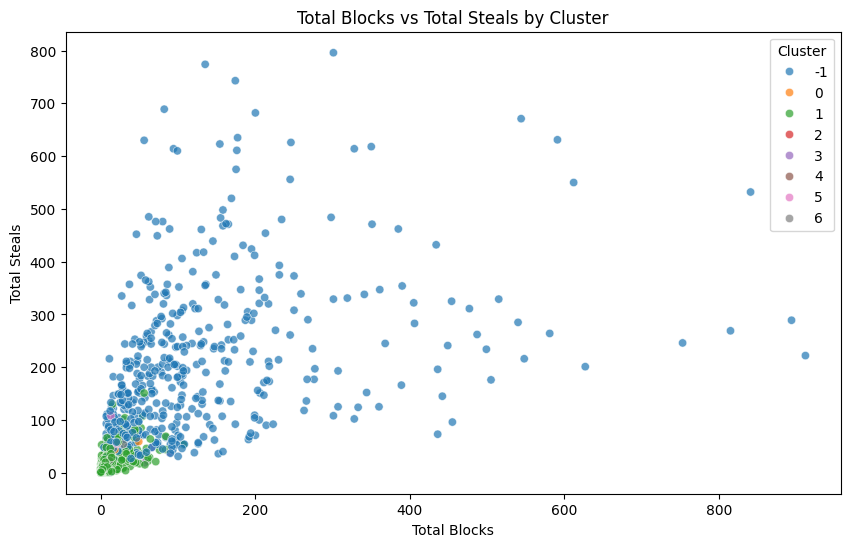

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=defense_df,
    x='total_blocks',
    y='total_steals',
    hue='Cluster',
    palette='tab10',
    alpha=0.7
)
plt.title('Total Blocks vs Total Steals by Cluster')
plt.xlabel('Total Blocks')
plt.ylabel('Total Steals')
plt.legend(title='Cluster')
plt.show()


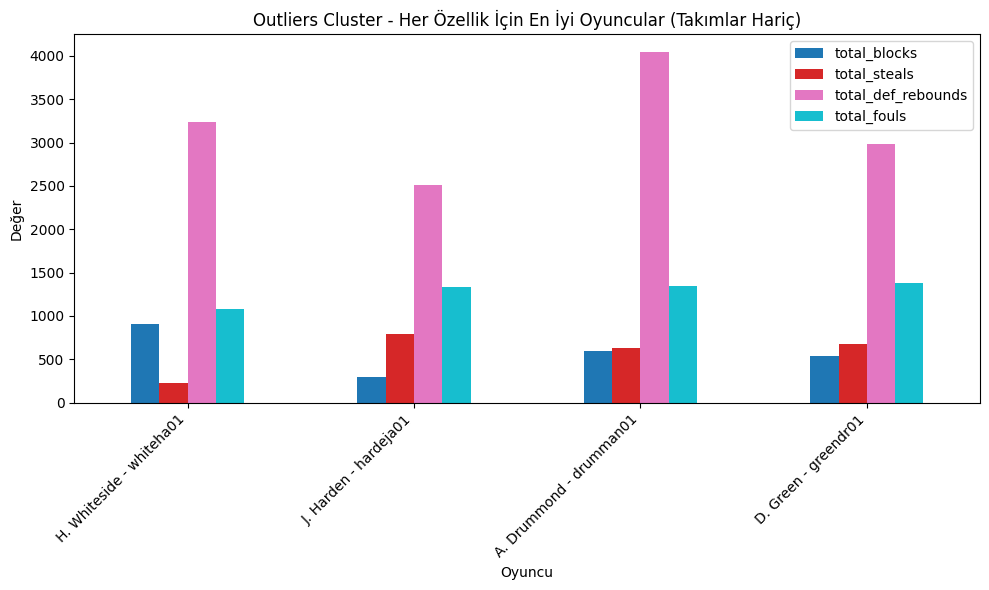

In [ ]:
# Outlier cluster oyuncuları
outliers = defense_df[(defense_df['Cluster'] == -1) & (~defense_df['Player'].str.lower().str.contains("team"))].copy()

# Her özellik için en iyi oyuncu (en yüksek değer)
best_block = outliers.loc[outliers['total_blocks'].idxmax()]
best_steal = outliers.loc[outliers['total_steals'].idxmax()]
best_rebound = outliers.loc[outliers['total_def_rebounds'].idxmax()]
best_foul = outliers.loc[outliers['total_fouls'].idxmax()]

# DataFrame oluştur
top_players = pd.DataFrame([best_block, best_steal, best_rebound, best_foul])

# Kullanılacak sütunlar
top_players = top_players[['total_blocks', 'total_steals', 'total_def_rebounds', 'total_fouls']]

# Oyuncu adlarını indeks olarak ayarla
top_players.index = [
    best_block['Player'],
    best_steal['Player'],
    best_rebound['Player'],
    best_foul['Player']
]

# Görselleştirme
top_players.plot(kind='bar', figsize=(10,6), colormap='tab10')
plt.title('Outliers Cluster - Her Özellik İçin En İyi Oyuncular (Takımlar Hariç)')
plt.ylabel('Değer')
plt.xlabel('Oyuncu')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
print(defense_df.dtypes)

Player                    object
block_far                float64
block_mid                float64
block_near               float64
total_blocks             float64
avg_block_dist           float64
total_steals             float64
total_def_rebounds       float64
foul_away from play      float64
foul_clear path          float64
foul_def 3 sec tech      float64
foul_flagrant            float64
foul_inbound             float64
foul_loose ball          float64
foul_offensive           float64
foul_offensive charge    float64
foul_personal            float64
foul_personal block      float64
foul_personal take       float64
foul_shooting            float64
foul_shooting block      float64
foul_technical           float64
total_fouls              float64
Cluster                    int64
dtype: object


Simdi sadece clutch anlardaki defansif performansları inceleyelim olusturdugumuz defense_df yi filtreleyerek, sadece fouled satırını alarak bir offense_df olusturalım, bunu yaparken bir önceki satırdan foul yapılan oyuncunun hangi mesafede foule hangi atış tarzıyla ve hangi oyuncular maruz kalıyor ve bunu neyle ilişkilendirebiliriz bir bakalım.

In [ ]:
# --- GENEL FOUL ALAN OYUNCULAR ---

# 1. Fouled olan satırları al
foul_plays = df[df['Fouled'].notnull()].copy()

# 2. ShotDist bilgisini bir önceki satırdan al
foul_plays['ShotDist'] = df.loc[foul_plays.index - 1, 'ShotDist'].values

# 3. Sadece gerekli sütunlar
offensive_df = foul_plays[['Fouled', 'ShotDist']].copy()
offensive_df.rename(columns={'Fouled': 'Player'}, inplace=True)

# 4. Eksik shotdist verileri olanları çıkar
offensive_df = offensive_df.dropna(subset=['ShotDist'])

# 5. Ölçekleme ve DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

features = offensive_df.drop(columns=['Player'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

dbscan = DBSCAN(eps=1.0, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)

offensive_df['Cluster'] = clusters

# 6. Küme içi oyunculara bakalım
print(offensive_df.groupby('Cluster').size())
print("\nKüme - Ortalama Şut Mesafeleri")
print(offensive_df.groupby('Cluster')['ShotDist'].mean())


Cluster
0    3035
1       7
dtype: int64

Küme - Ortalama Şut Mesafeleri
Cluster
0    10.026030
1    80.571429
Name: ShotDist, dtype: float64


En cok foul yapılan oyuncular içinden rastgele 10 unu alalım.

In [ ]:
top_fouled = offensive_df['Player'].value_counts().head(10)
print("En Çok Foul Alan Oyuncular:")
print(top_fouled)


En Çok Foul Alan Oyuncular:
Player
T. Young - youngtr01            44
N. Jokić - jokicni01            40
G. Antetokounmpo - antetgi01    38
Z. Williamson - willizi01       35
D. Lillard - lillada01          35
L. Dončić - doncilu01           33
H. Barnes - barneha02           32
D. Fox - foxde01                32
D. Sabonis - sabondo01          29
A. Drummond - drumman01         29
Name: count, dtype: int64


Şimdi çıkan sonuçlarda benim dikkatimi şu çekti Jokic ve Antetoukompou 2 şer defa mvp olmuslar ki altta mvp listesinin ss'ini koydum ordan da görebiliriz. Anlaşılan bu oyuncular ofansif anlamda savunması en zor oyunculardan ki antetoukompou nun defansif anllamda da başrısını gördük ligin en komple oyuncusu dersek yanlış olmayabilir.

Şimdi sıra comnbined_df mizi her çeyrekte son 2 dakikaya göre filtreleyerkek analiz edelim ki hangi oyuncular clutch anlarda daha değerli ve daha çok foulle durduruluyor anlamaya çalısalım.

In [ ]:
# Her çeyreğin son 120 saniyesi
clutch_df = combined_df[combined_df['SecLeft'] <= 120].copy()


In [ ]:
clutch_df = combined_df[combined_df['SecLeft'] <= 120].copy()

# --- BLOCK ---
def categorize_distance(dist):
    if dist <= 5:
        return 'near'
    elif dist <= 15:
        return 'mid'
    else:
        return 'far'

blocks = clutch_df[clutch_df['Blocker'].notnull() & clutch_df['ShotDist'].notnull()].copy()
blocks['BlockRange'] = blocks['ShotDist'].apply(categorize_distance)

block_ohe = blocks.groupby(['Blocker', 'BlockRange']).size().unstack(fill_value=0).reset_index()
block_ohe = block_ohe.rename(columns={'Blocker': 'Player'})

for col in ['near', 'mid', 'far']:
    if col in block_ohe.columns:
        block_ohe.rename(columns={col: f'block_{col}'}, inplace=True)

block_cols = [col for col in block_ohe.columns if col.startswith('block_')]
block_ohe['total_blocks'] = block_ohe[block_cols].sum(axis=1)

block_avg_dist = blocks.groupby('Blocker')['ShotDist'].mean().reset_index().rename(columns={'Blocker': 'Player', 'ShotDist': 'avg_block_dist'})

# --- STEAL ---
steals = clutch_df[clutch_df['TurnoverCause'] == 'steal'].copy()
steal_counts = steals.groupby('TurnoverCauser').size().reset_index(name='total_steals')
steal_counts = steal_counts.rename(columns={'TurnoverCauser': 'Player'})

# --- DEFENSIVE REBOUNDS ---
def_rebounds = clutch_df[clutch_df['ReboundType'] == 'defensive']
rebound_stats = def_rebounds.groupby('Rebounder').size().reset_index(name='total_def_rebounds').rename(columns={'Rebounder': 'Player'})

# --- FOULS ---
fouls = clutch_df[clutch_df['Fouler'].notnull()].copy()
if 'FoulType' in fouls.columns:
    foul_ohe = fouls.groupby(['Fouler', 'FoulType']).size().unstack(fill_value=0).reset_index()
else:
    fouls['FoulType'] = 'defensive'  # fallback
    foul_ohe = fouls.groupby(['Fouler', 'FoulType']).size().unstack(fill_value=0).reset_index()

foul_ohe = foul_ohe.rename(columns={'Fouler': 'Player'})
for col in foul_ohe.columns:
    if col != 'Player':
        foul_ohe.rename(columns={col: f'foul_{col}'}, inplace=True)
foul_cols = [col for col in foul_ohe.columns if col.startswith('foul_')]
foul_ohe['total_fouls'] = foul_ohe[foul_cols].sum(axis=1)

# --- MERGE ---
from functools import reduce
dfs = [block_ohe, block_avg_dist, steal_counts, rebound_stats, foul_ohe]
defense_df = reduce(lambda left, right: pd.merge(left, right, on='Player', how='outer'), dfs).fillna(0)

# --- CLUSTERING ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

features = defense_df.drop(columns=['Player'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

dbscan = DBSCAN(eps=1.0, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)
defense_df['Cluster'] = clusters

valid_mask = clusters != -1
if valid_mask.sum() > 1 and len(np.unique(clusters[valid_mask])) > 1:
    silhouette = silhouette_score(X_scaled[valid_mask], clusters[valid_mask])
    print("Silhouette Score (Clutch):", silhouette)
else:
    print("Silhouette score hesaplanamadı (tek küme ya da fazla noise olabilir).")

# Küme ortalamaları
print(defense_df.groupby('Cluster').mean(numeric_only=True))


Silhouette Score (Clutch): 0.19642456801831457
         block_far  block_mid  block_near  total_blocks  avg_block_dist  \
Cluster                                                                   
-1        2.720081   3.817444   16.490872     23.028398        6.666842   
 0        0.164948   0.323711    1.249485      1.738144        2.893395   
 1        0.000000   0.333333    1.000000      1.333333        2.111111   
 2        0.125000   0.250000    1.125000      1.500000        2.937500   
 3        0.000000   0.666667    1.000000      1.666667        4.833333   
 4        0.000000   2.750000    6.750000      9.500000        3.859307   
 5        0.000000   0.100000    0.700000      0.800000        1.466667   
 6        0.000000   0.000000    2.666667      2.666667        2.633333   
 7        1.000000   0.000000    2.333333      3.333333        8.861111   

         total_steals  total_def_rebounds  foul_away from play  \
Cluster                                                      

Silhoute scorumuz 0.19 geldi ve bu aslında baya kötü bi kümeleme yaptığını gösteriyor ama bunun sebebinin clutch anlarda çok fazla 0 ve boş veri gelmesi oldugunu düşünüyorum bu da verinin ayrıştırılmasını ekstra zorlaştırmış olabilir.

In [ ]:
# Cluster -1'deki oyuncular
noise_players = defense_df[defense_df['Cluster'] == -1].copy()

# Toplam katkı skoru oluştur
noise_players['total_contribution'] = (
    noise_players.get('total_blocks', 0) +
    noise_players.get('total_steals', 0) +
    noise_players.get('total_def_rebounds', 0) -
    noise_players.get('total_fouls', 0)  # negatif etki
)

# En yüksek katkı yapan oyuncuları sırala
top_noise_players = noise_players.sort_values(by='total_contribution', ascending=False)

# En iyi 5 oyuncuyu göster
print(top_noise_players[['Player', 'total_blocks', 'total_steals', 'total_def_rebounds', 'total_fouls', 'total_contribution']].head(5))


                           Player  total_blocks  total_steals  \
971                          Team           0.0           0.0   
18           A. Davis - davisan02         146.0          85.0   
19        A. Drummond - drumman01          95.0          84.0   
320  G. Antetokounmpo - antetgi01         133.0          94.0   
610          L. James - jamesle01          59.0          84.0   

     total_def_rebounds  total_fouls  total_contribution  
971              5680.0          0.0              5680.0  
18                518.0        168.0               581.0  
19                631.0        235.0               575.0  
320               591.0        270.0               548.0  
610               513.0        158.0               498.0  


Şimdi de clutch anlarda savunma performansı en yüksek 5 oyuncuya bakalım ve aşağı mvp listesini koydum bakalım bu oyuncularla o liste çakışıyor mu?

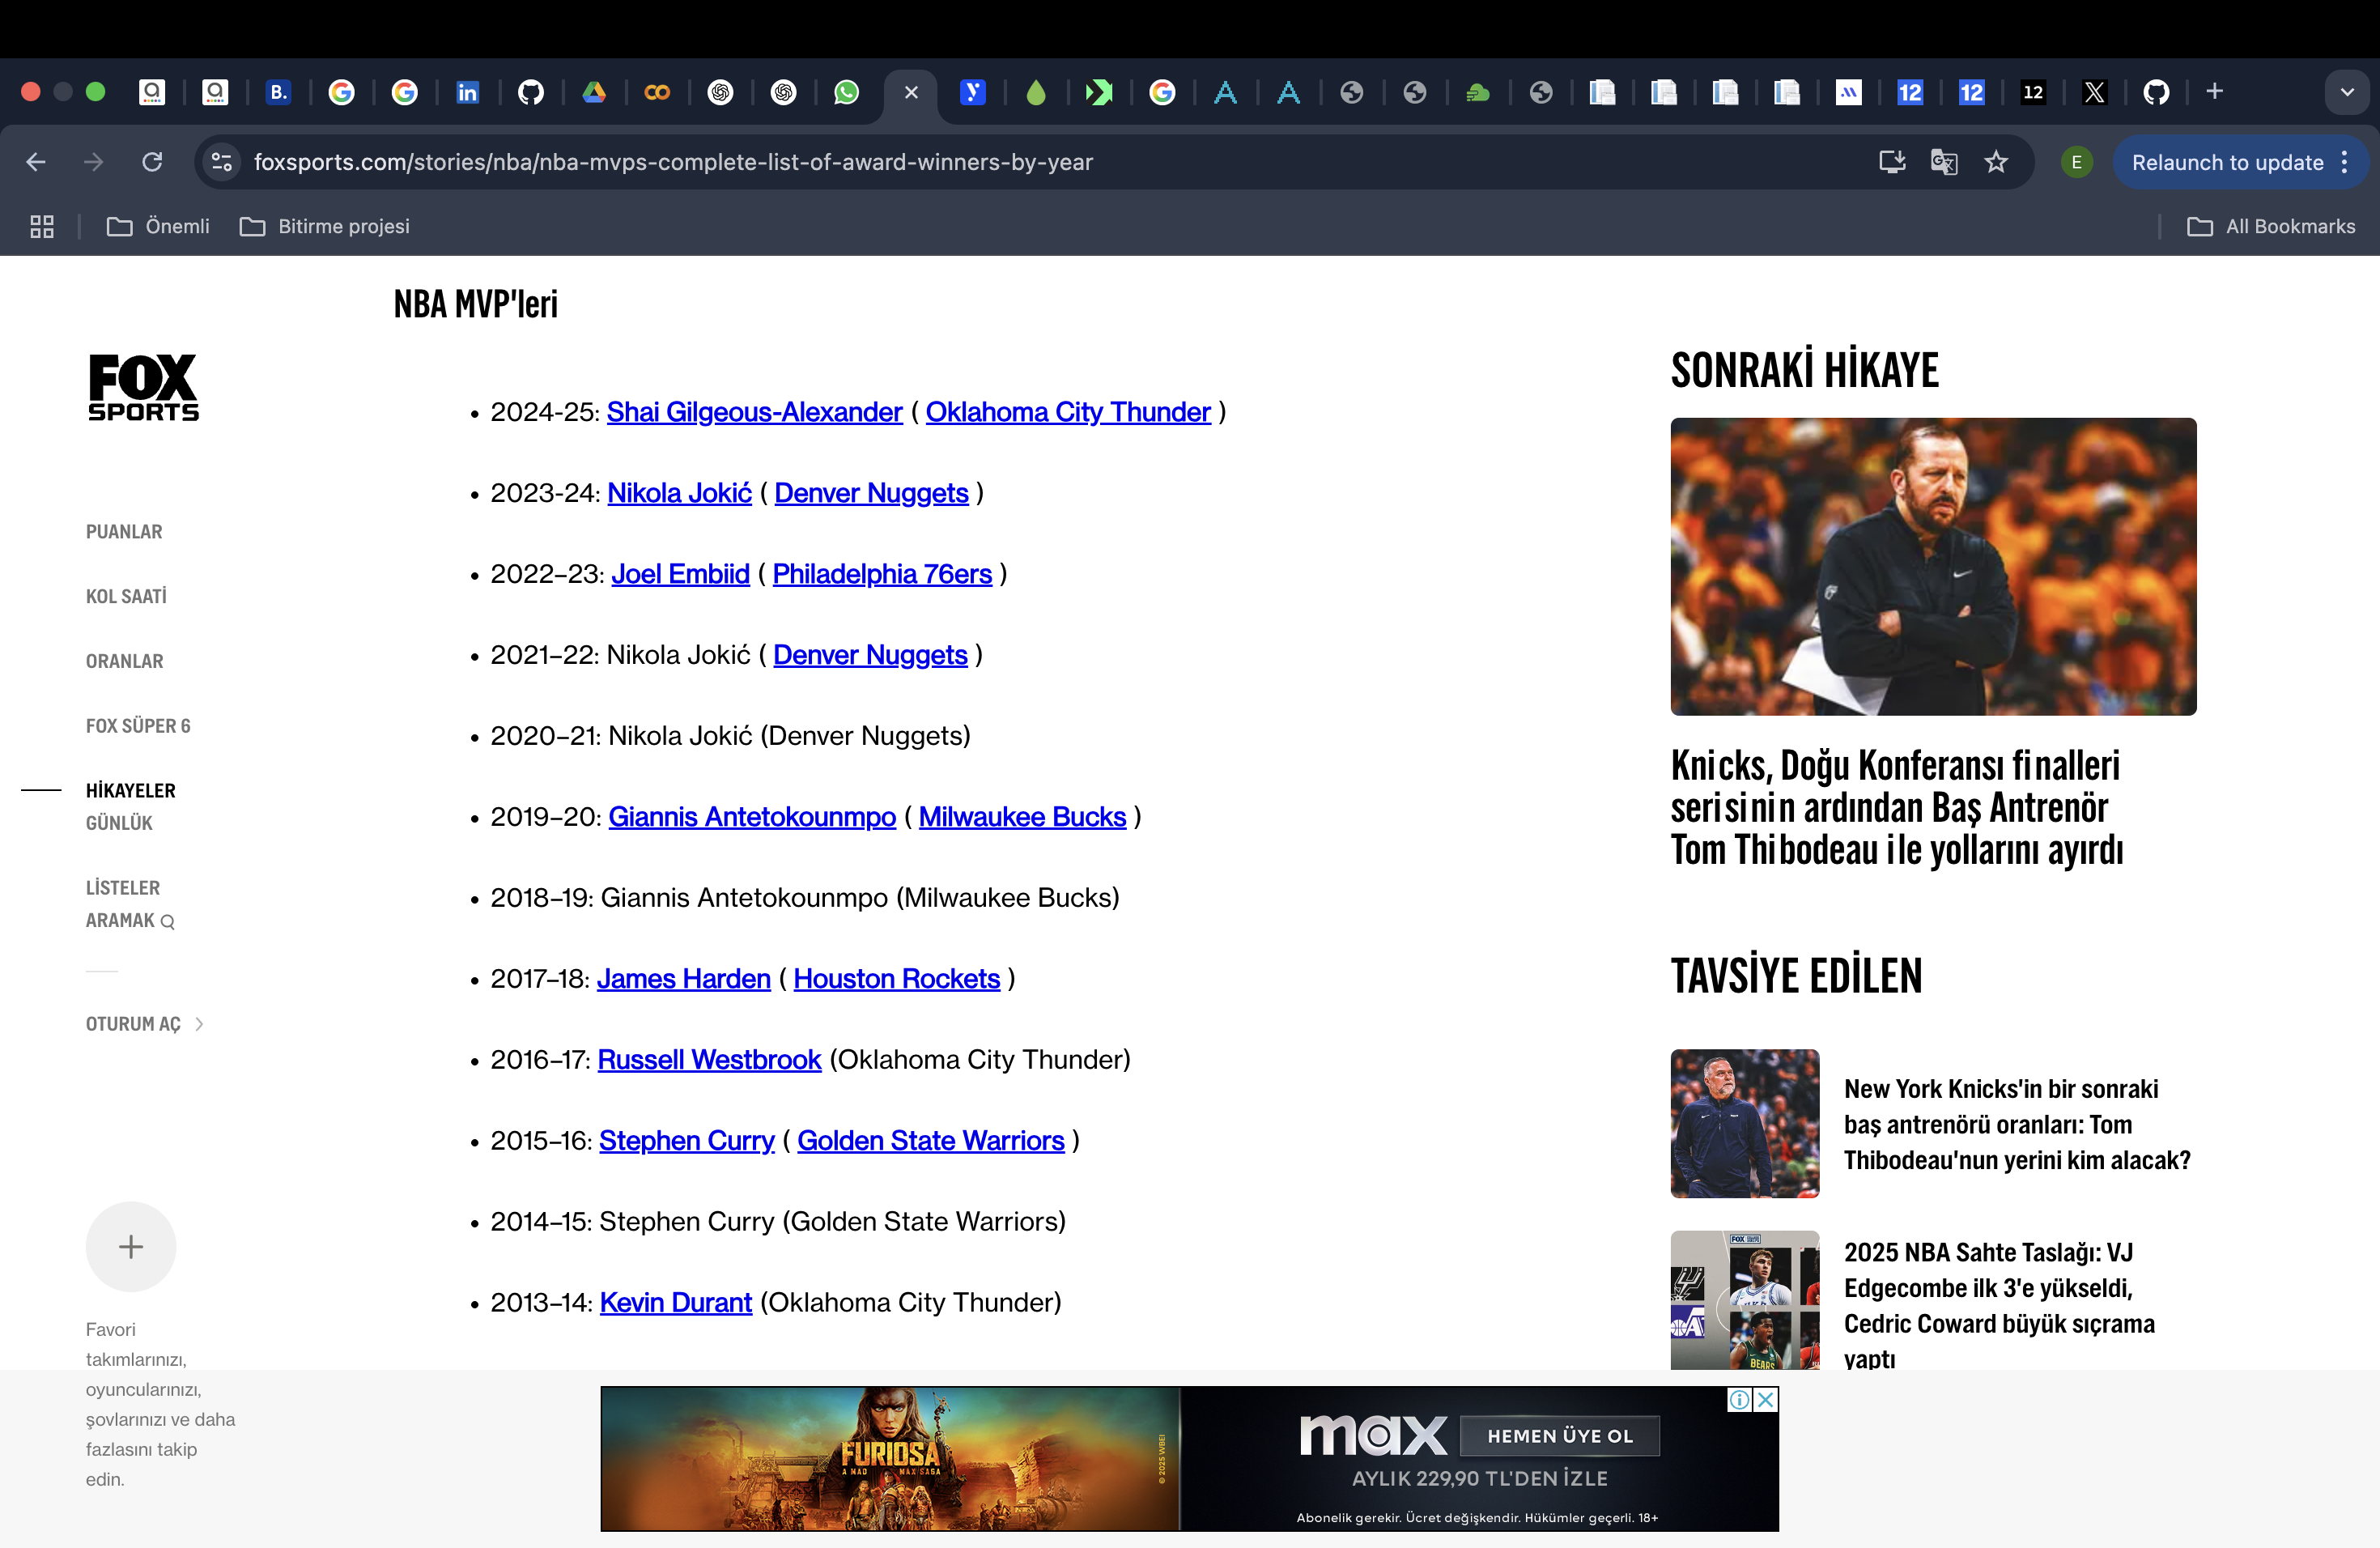

Clutch anlarda öne çıkan oyuncularımızdan antetoukoumpo nun 2 defa mvp seçildiğini görüyoruz, ayrıca clutch dışı bütün maç anlarında yaptığımız analizlerde james harden ve russel wetbrook en iyi savunma alanlarında 2 listede ön plandaydı yani defansif bir fundamentalin mvp seçimlerinde ne kadar etkili olduğunu gözle görebiliyoruz.

In [ ]:
# Clutch: Her çeyreğin son 120 saniyesi
clutch_df = combined_df[combined_df['SecLeft'] <= 120].copy()
# Faul yapılan oyuncular (Fouled sütunu dolu olmalı)
clutch_fouls = clutch_df[clutch_df['Fouled'].notnull()].copy()

# ShotDist değerini de taşıyan sadece geçerli satırlar
clutch_fouls = clutch_fouls[clutch_fouls['ShotDist'].notnull()]
offensive_pressure_df = clutch_fouls[['Fouled', 'ShotDist']].copy()
offensive_pressure_df = offensive_pressure_df.rename(columns={'Fouled': 'Player'})
def categorize_distance(dist):
    if dist <= 5:
        return 'near'
    elif dist <= 15:
        return 'mid'
    else:
        return 'far'

offensive_pressure_df['Range'] = offensive_pressure_df['ShotDist'].apply(categorize_distance)


In [ ]:
print(clutch_fouls.shape)


(0, 42)


In [ ]:
# Bölge bazlı one-hot encoding
off_ohe = offensive_pressure_df.groupby(['Player', 'Range']).size().unstack(fill_value=0).reset_index()

# Kolon isimlerini değiştir
for col in ['near', 'mid', 'far']:
    if col in off_ohe.columns:
        off_ohe.rename(columns={col: f'foul_{col}'}, inplace=True)

# Toplam faul sayısı
foul_cols = [col for col in off_ohe.columns if col.startswith('foul_')]
off_ohe['total_clutch_fouls'] = off_ohe[foul_cols].sum(axis=1)

# Ortalama shot distance
avg_dist = offensive_pressure_df.groupby('Player')['ShotDist'].mean().reset_index().rename(columns={'ShotDist': 'avg_foul_dist'})

# Birleştir
offensive_df = pd.merge(off_ohe, avg_dist, on='Player')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

features = offensive_df.drop(columns=['Player'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

dbscan = DBSCAN(eps=1.0, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)
offensive_df['Cluster'] = clusters


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by StandardScaler.

In [ ]:
# Gürültü olmayan oyuncular (isteğe bağlı filtre)
top_offensive = offensive_df[offensive_df['Cluster'] != -1]

# Toplam clutch foul sayısına göre sırala
top_offensive_sorted = top_offensive.sort_values(by='total_clutch_fouls', ascending=False)

# En etkili 10 oyuncu
print(top_offensive_sorted[['Player', 'total_clutch_fouls', 'avg_foul_dist']].head(10))


Şimdi de defense_df den her defansif toplam istatistiği takım bazlı filtreleyelim ve bakalım , takımları kümeleyip takımların zayıf yönlerini analiz etmeye çalışalım. Burda Kmeans kullanıp daha iyi bir clustering elde etmeliyim, bu sefer bütün sınıflara ihtiyacım var.

In [11]:
def get_defense_team(row):
    if pd.notna(row['HomePlay']):  # HomePlay doluysa
        return row['AwayTeam']
    elif pd.notna(row['AwayPlay']):  # AwayPlay doluysa
        return row['HomeTeam']
    else:
        return np.nan

# Savunma takımı sütunu ekle
combined_df['DefenseTeam'] = combined_df.apply(get_defense_team, axis=1)


In [14]:
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import KFold

# --- Verileri hazırlama ---
blocks = combined_df[combined_df['Blocker'].notnull()]
block_stats = blocks.groupby('DefenseTeam').agg(
    total_blocks=('Blocker', 'count'),
    avg_block_dist=('ShotDist', 'mean')
).reset_index().rename(columns={'DefenseTeam': 'Team'})

steals = combined_df[combined_df['TurnoverCause'].notnull()]
steal_stats = steals.groupby('DefenseTeam').agg(
    total_steals=('TurnoverCause', 'count')
).reset_index().rename(columns={'DefenseTeam': 'Team'})

def_rebounds = combined_df[combined_df['ReboundType'] == 'defensive']
def_rebound_stats = def_rebounds.groupby('DefenseTeam').agg(
    total_def_rebounds=('Rebounder', 'count')
).reset_index().rename(columns={'DefenseTeam': 'Team'})

fouls = combined_df[combined_df['Fouler'].notnull()]
defensive_fouls = fouls.groupby('DefenseTeam').agg(
    total_fouls=('Fouler', 'count')
).reset_index().rename(columns={'DefenseTeam': 'Team'})

dfs = [block_stats, steal_stats, def_rebound_stats, defensive_fouls]
team_defense_df = reduce(lambda left, right: pd.merge(left, right, on='Team', how='outer'), dfs)
team_defense_df.fillna(0, inplace=True)

# --- Özellikler & Ölçekleme ---
features = team_defense_df[['total_blocks', 'avg_block_dist', 'total_steals', 'total_def_rebounds', 'total_fouls']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- KMeans + CV ile Kümeleme ve Değerlendirme Fonksiyonu ---
def evaluate_kmeans(X, k_range=range(2, 6), n_splits=5):
    np.random.seed(42)
    results = []
    num_samples = X.shape[0]
    max_k = max(2, num_samples - 1)
    k_range = [k for k in k_range if k <= max_k]  # Küme sayısını veri sayısına uydur

    for k in k_range:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        sil_scores = []
        ari_scores = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]

            model = KMeans(n_clusters=k, random_state=42, n_init=10)
            model.fit(X_train)

            # Test verisi için tahmin
            labels_test = model.predict(X_test)

            # Silhouette sadece test verisi için, en az 2 küme olmalı
            if len(set(labels_test)) > 1:
                sil = silhouette_score(X_test, labels_test)
            else:
                sil = np.nan

            # Adjusted Rand Index: Kendi model kümesi ile test tahmini karşılaştırması
            # Ama elimizde gerçek etiket yok, burada kendi tahminlerimizle karşılaştırma yapabiliriz
            # Bu yüzden ARI anlamsız olabilir; örnek olarak train üzerindeki label ile test label karşılaştırdık
            labels_train = model.labels_
            ari = adjusted_rand_score(labels_train[:len(test_index)], labels_test)

            sil_scores.append(sil)
            ari_scores.append(ari)

        results.append({
            'k': k,
            'silhouette_mean': np.nanmean(sil_scores),
            'silhouette_std': np.nanstd(sil_scores),
            'ari_mean': np.mean(ari_scores),
            'ari_std': np.std(ari_scores)
        })
    return pd.DataFrame(results)

# --- Değerlendirme ---
result_df = evaluate_kmeans(X_scaled, k_range=range(2, 8), n_splits=5)
print(result_df)


   k  silhouette_mean  silhouette_std  ari_mean   ari_std
0  2         0.347750        0.034155 -0.040000  0.080000
1  3         0.176742        0.165456 -0.102668  0.089268
2  4         0.155463        0.123976 -0.136850  0.182896
3  5         0.044156        0.169414 -0.136097  0.143937
4  6        -0.016165        0.108812  0.090965  0.195122
5  7         0.036527        0.171185 -0.052133  0.151896


Şimdi sonucları incelediğimde küme sayısının 2 olması ayrıstırma acısından en yüksek yüzdeyi vermis ama yine de ari sonucuna baktıgımızdda modelin kendi içinde tutarsız olduğunu gösteriyor, bunun sebebi takımların istatistiklerinin birbirine çok yakın olması. Bundan dolayı algoritma ayrıştırma yaparken zorlaanıyor ve tutarlılığa sahip değil.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

def evaluate_kmeans(X_scaled, k_range=range(2, 7), n_splits=5):
    results = []

    for k in k_range:
        # Silhouette Score
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
        silhouette = silhouette_score(X_scaled, kmeans.labels_)

        # Cross-Validation ARI
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        ari_scores = []

        for train_index, test_index in kf.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            kmeans_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
            kmeans_test = KMeans(n_clusters=k, random_state=42).fit(X_test)

            labels_train = kmeans_train.predict(X_train)
            labels_test = kmeans_test.predict(X_test)

            # Kısa karşılaştırma yapmak için boyutu eşitle
            min_len = min(len(labels_train), len(labels_test))
            ari = adjusted_rand_score(labels_train[:min_len], labels_test[:min_len])
            ari_scores.append(ari)

        mean_ari = np.mean(ari_scores)

        results.append({
            'K': k,
            'Silhouette Score': round(silhouette, 4),
            'Avg ARI Score': round(mean_ari, 4)
        })

    return pd.DataFrame(results)

# Örnek kullanım:
# X_scaled önceki kodundaki ölçeklenmiş veri olmalı
result_df = evaluate_kmeans(X_scaled, k_range=range(2, 7), n_splits=5)
print(result_df)


   K  Silhouette Score  Avg ARI Score
0  2            0.4938        -0.0348
1  3            0.2623        -0.1079
2  4            0.2387        -0.1967
3  5            0.2024        -0.1271
4  6            0.2059         0.0000


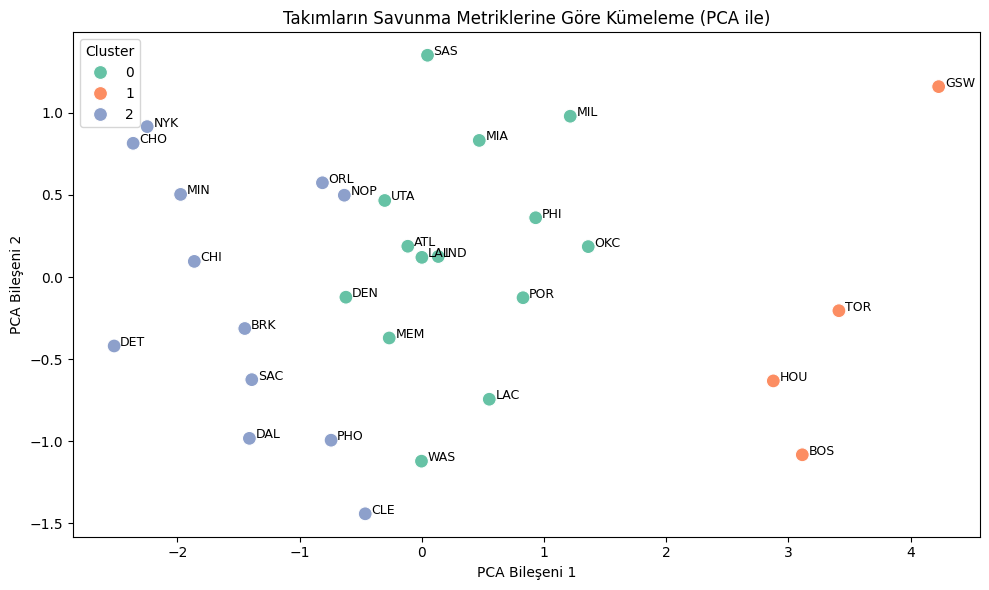

Cluster ortalamaları:
         total_blocks  total_steals  total_def_rebounds   total_fouls
Cluster                                                              
0         2233.428571   3446.857143        15850.142857   9321.071429
1         2547.750000   3980.750000        17353.250000  10267.750000
2         1906.583333   3108.250000        15503.000000   8653.583333


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. Gerekli metriklerle takım bazlı ortalama savunma verisi
team_defense = team_defense_df.groupby('Team').agg({
    'total_blocks': 'mean',
    'total_steals': 'mean',
    'total_def_rebounds': 'mean',
    'total_fouls': 'mean'
}).reset_index()

# 2. Ölçekleme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(team_defense.drop(columns=['Team']))

# 3. KMeans ile clustering (örn. 3 cluster)
kmeans = KMeans(n_clusters=3, random_state=42)
team_defense['Cluster'] = kmeans.fit_predict(X_scaled)

# 4. PCA ile görselleştirme
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=team_defense['Cluster'], palette='Set2', s=100)
for i, team in enumerate(team_defense['Team']):
    plt.text(pca_result[i,0]+0.05, pca_result[i,1], team, fontsize=9)
plt.title('Takımların Savunma Metriklerine Göre Kümeleme (PCA ile)')
plt.xlabel('PCA Bileşeni 1')
plt.ylabel('PCA Bileşeni 2')
plt.tight_layout()
plt.show()

# 5. Cluster ortalamaları (zayıf yönleri analiz için)
cluster_means = team_defense.groupby('Cluster').mean(numeric_only=True)
print("Cluster ortalamaları:")
print(cluster_means)


Şimdi de takımların zayıf yanlarını bulmak için her takımın toplam istatistiğinden ortalama lig istatistiğini çıkararak zayıf oldukları alanları bulalaım.

In [20]:
# Tüm takımların genel ortalaması
overall_avg = team_defense[['total_blocks', 'total_steals', 'total_def_rebounds', 'total_fouls']].mean()

weakest_aspect = []
for idx, row in team_defense.iterrows():
    differences = {
        metric: row[metric] - overall_avg[metric]
        for metric in ['total_blocks', 'total_steals', 'total_def_rebounds', 'total_fouls']
    }
    weakest_metric = min(differences, key=differences.get)
    weakest_aspect.append(weakest_metric)

team_defense['Weakest_Def_Aspect'] = weakest_aspect

print(team_defense[['Team', 'Weakest_Def_Aspect']])


   Team  Weakest_Def_Aspect
0   ATL  total_def_rebounds
1   BOS        total_blocks
2   BRK        total_steals
3   CHI         total_fouls
4   CHO         total_fouls
5   CLE        total_blocks
6   DAL        total_steals
7   DEN  total_def_rebounds
8   DET         total_fouls
9   GSW        total_steals
10  HOU        total_blocks
11  IND         total_fouls
12  LAC        total_blocks
13  LAL         total_fouls
14  MEM  total_def_rebounds
15  MIA        total_steals
16  MIL         total_fouls
17  MIN  total_def_rebounds
18  NOP         total_fouls
19  NYK  total_def_rebounds
20  OKC  total_def_rebounds
21  ORL         total_fouls
22  PHI  total_def_rebounds
23  PHO  total_def_rebounds
24  POR        total_steals
25  SAC  total_def_rebounds
26  SAS         total_fouls
27  TOR        total_blocks
28  UTA  total_def_rebounds
29  WAS        total_blocks


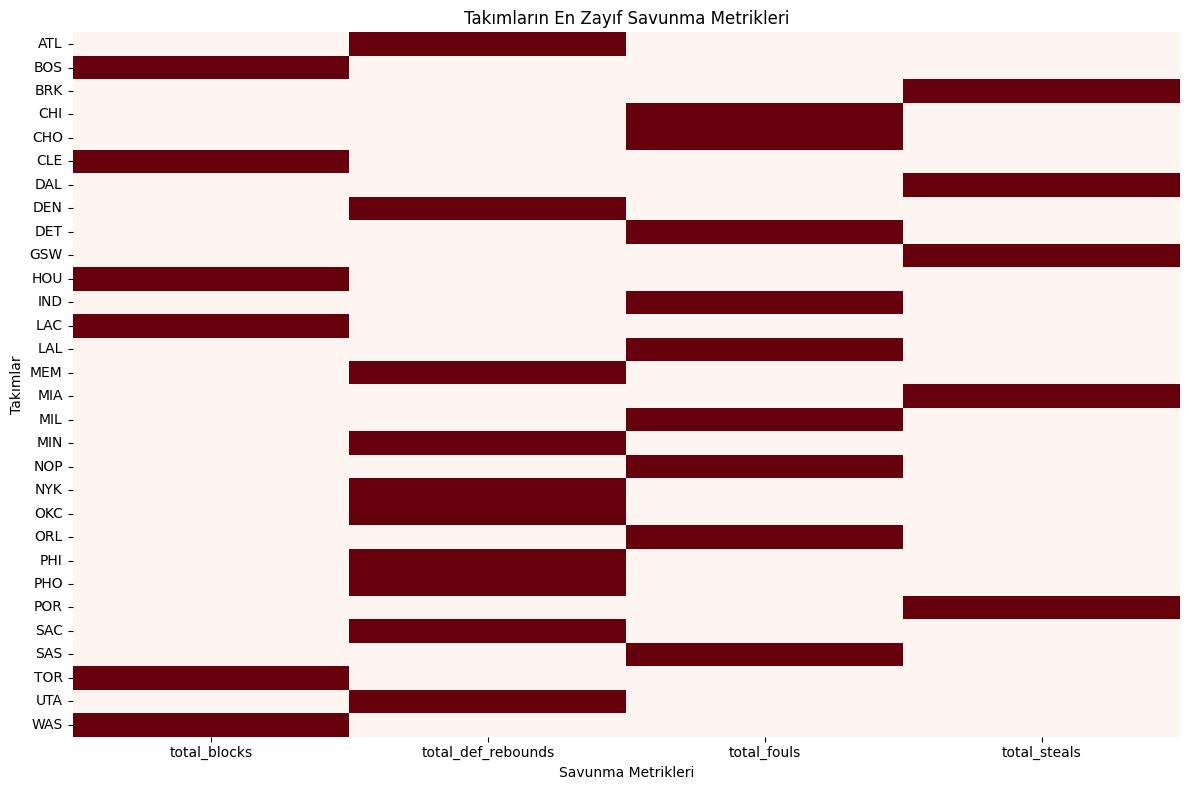

In [21]:
# Pivot table
pivot = team_defense.pivot(index='Team', columns='Weakest_Def_Aspect', values='Cluster')

# Heatmap (renkli hangi metrikte zayıflık var)
plt.figure(figsize=(12, 8))
sns.heatmap(pd.get_dummies(team_defense.set_index('Team')['Weakest_Def_Aspect']), cmap='Reds', cbar=False)
plt.title("Takımların En Zayıf Savunma Metrikleri")
plt.xlabel("Savunma Metrikleri")
plt.ylabel("Takımlar")
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# ==========================================
# --- SHOTS ---
shots = combined_df[combined_df['Shooter'].notnull()].copy()

# Toplam şut ve isabetli şut
total_shots = shots.groupby('Shooter').size().reset_index(name='total_shots')
made_shots = shots[shots['ShotOutcome'] == 'make'].groupby('Shooter').size().reset_index(name='made_shots')

# Ortalama şut mesafesi
avg_dist = shots.groupby('Shooter')['ShotDist'].mean().reset_index().rename(columns={'ShotDist': 'avg_shot_distance'})

# FG%
fg_df = pd.merge(total_shots, made_shots, on='Shooter', how='left').fillna(0)
fg_df['fg_percentage'] = np.where(fg_df['total_shots'] > 0, fg_df['made_shots'] / fg_df['total_shots'], 0)

# ==========================================
# --- ASSISTS ---
assists = combined_df[combined_df['Assister'].notnull()]
assist_counts = assists.groupby('Assister').size().reset_index(name='total_assists')
assist_counts = assist_counts.rename(columns={'Assister': 'Player'})

# ==========================================
# --- TURNOVERS ---
turnovers = combined_df[combined_df['TurnoverPlayer'].notnull()]
turnover_counts = turnovers.groupby('TurnoverPlayer').size().reset_index(name='total_turnovers')
turnover_counts = turnover_counts.rename(columns={'TurnoverPlayer': 'Player'})

# ==========================================
# --- FREE THROWS ---
fts = combined_df[combined_df['FreeThrowShooter'].notnull()]

fts_total = fts.groupby('FreeThrowShooter').size().reset_index(name='total_fts')
fts_made = fts[fts['FreeThrowOutcome'] == 'make'].groupby('FreeThrowShooter').size().reset_index(name='made_fts')

fts_df = pd.merge(fts_total, fts_made, on='FreeThrowShooter', how='left').fillna(0)
fts_df = fts_df.rename(columns={'FreeThrowShooter': 'Player'})

fts_df['ft_percentage'] = np.where(
    fts_df['total_fts'] > 0,
    fts_df['made_fts'] / fts_df['total_fts'],
    0
)

# ==========================================
# --- Merge tüm hücum istatistikleri ---
fg_df = fg_df.rename(columns={'Shooter': 'Player'})
avg_dist = avg_dist.rename(columns={'Shooter': 'Player'})

dfs = [fg_df, avg_dist, assist_counts, turnover_counts, fts_df]
offense_df = reduce(lambda left, right: pd.merge(left, right, on='Player', how='outer'), dfs).fillna(0)

# ==========================================
# --- Clustering (DBSCAN) ---
features = offense_df.drop(columns=['Player'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

dbscan = DBSCAN(eps=1.2, min_samples=3)
clusters = dbscan.fit_predict(X_scaled)
offense_df['Cluster'] = clusters

valid_mask = clusters != -1
if valid_mask.sum() > 1 and len(np.unique(clusters[valid_mask])) > 1:
    silhouette = silhouette_score(X_scaled[valid_mask], clusters[valid_mask])
    print("Silhouette Score:", silhouette)
else:
    print("Silhouette score hesaplanamadı (tek küme ya da fazla noise olabilir).")

# Küme ortalamaları (white noise dahil!)
print("\nTüm küme ortalamaları (white noise dahil):")
print(offense_df.groupby('Cluster').mean(numeric_only=True))




Silhouette Score: 0.45226277263505194

Tüm küme ortalamaları (white noise dahil):
         total_shots   made_shots  fg_percentage  avg_shot_distance  \
Cluster                                                               
-1       4018.314815  1923.222222       0.425488          11.031260   
 0        961.475584   435.304671       0.433484          13.106311   
 1          2.529412     0.000000       0.000000          20.669468   
 2       7086.333333  3244.666667       0.458037          16.435967   

         total_assists  total_turnovers    total_fts     made_fts  \
Cluster                                                             
-1         1369.277778       858.574074  1384.037037  1077.740741   
 0          242.080679       146.463907   235.125265   178.814225   
 1            0.705882         0.588235     0.000000     0.000000   
 2         2039.000000      1007.666667  1952.666667  1681.000000   

         ft_percentage  
Cluster                 
-1            0.706947  
 

In [20]:

def classify_shot_distance(dist):
    if dist <= 8:   return "close"
    elif dist <= 20:return "mid"
    else:           return "long"

offense_df["shot_range"] = offense_df["avg_shot_distance"].apply(classify_shot_distance)


offense_df = pd.get_dummies(offense_df, columns=["shot_range"])


offense_df = offense_df.loc[:, ~offense_df.columns.duplicated()]
offense_df = offense_df.reset_index(drop=True)


eligible_players = offense_df[offense_df["total_shots"] >= 500].copy()
eligible_players = eligible_players.reset_index(drop=True)   # garanti


feature_cols = [
    "total_shots","made_shots","fg_percentage","avg_shot_distance",
    "total_assists","total_turnovers","total_fts","made_fts","ft_percentage",
    "shot_range_close","shot_range_mid","shot_range_long"
]
X = eligible_players[feature_cols]
X_scaled = StandardScaler().fit_transform(X)

eligible_players["Cluster"] = DBSCAN(eps=1.2,min_samples=3).fit_predict(X_scaled)


print("\n🔟  Her Cluster’dan İlk 10 Oyuncu:")
for cid in sorted(eligible_players["Cluster"].unique()):
    print(f"\n--- Cluster {cid} ---")
    print(eligible_players[eligible_players["Cluster"]==cid]
          .head(10)[["Player","total_shots","made_shots","fg_percentage",
                      "avg_shot_distance","total_assists","total_turnovers",
                      "total_fts","made_fts","ft_percentage"]].to_string(index=False))


def print_top(df,col,asc,title):
    print(f"\n🏅  En iyi oyuncular – {title}")
    print(df.sort_values(col,ascending=asc)[["Player",col,"Cluster"]].head(10).to_string(index=False))

print_top(eligible_players,"fg_percentage",False,"Field-Goal %")
print_top(eligible_players,"ft_percentage",False,"Free-Throw %")
print_top(eligible_players,"total_assists",False,"Toplam Asist")
print_top(eligible_players,"total_fts",False,"Serbest Atış")
print_top(eligible_players,"total_shots",False,"Toplam Şut")
print_top(eligible_players,"avg_shot_distance",True,"En Kısa Mesafe")
print_top(eligible_players,"total_turnovers",True,"En Az Top Kaybı")




mid_range_shooters = eligible_players[eligible_players['shot_range_mid'] == True]
print("\n🎯 En İyi *Orta* Mesafe Şutörleri (Başarılı Şut Sayısı Bazlı):")
print(mid_range_shooters.sort_values(by='made_shots', ascending=False)[['Player', 'made_shots', 'Cluster']]
      .head(10).to_string(index=False))


long_range_shooters = eligible_players[eligible_players['shot_range_long'] == True]
print("\n🎯 En İyi *Uzun* Mesafe Şutörleri (Başarılı Şut Sayısı Bazlı):")
print(long_range_shooters.sort_values(by='made_shots', ascending=False)[['Player', 'made_shots', 'Cluster']]
      .head(10).to_string(index=False))




🔟  Her Cluster’dan İlk 10 Oyuncu:

--- Cluster -1 ---
                 Player  total_shots  made_shots  fg_percentage  avg_shot_distance  total_assists  total_turnovers  total_fts  made_fts  ft_percentage
   A. Davis - davisan02       7013.0      3610.0       0.514758          10.270070          998.0            827.0     2940.0    2378.0       0.808844
A. Drummond - drumman01       5004.0      2631.0       0.525779           3.836731          704.0            952.0     2175.0    1060.0       0.487356
 A. Horford - horfoal01       4777.0      2357.0       0.493406          13.233410         1753.0            646.0      708.0     564.0       0.796610
A. Iguodala - iguodan01       2109.0      1021.0       0.484116          14.620199         1277.0            384.0      512.0     314.0       0.613281
A. Roberson - roberan03       1058.0       510.0       0.482042           9.973535          200.0            136.0      246.0     104.0       0.422764
 A. Wiggins - wiggian01       6622.0   

In [15]:
print(offense_df.dtypes)

Player                object
total_shots          float64
made_shots           float64
fg_percentage        float64
avg_shot_distance    float64
total_assists        float64
total_turnovers      float64
total_fts            float64
made_fts             float64
ft_percentage        float64
Cluster                int64
shot_range_close        bool
shot_range_long         bool
shot_range_mid          bool
shot_range_close        bool
shot_range_long         bool
shot_range_mid          bool
dtype: object


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# --------------------------------------------------
# 1. Clutch Anlar – Veriyi Hazırla
# --------------------------------------------------
clutch_df = combined_df.copy()
clutch_df["minutes_remaining"] = clutch_df["SecLeft"] // 60
clutch_df["score_margin"] = (clutch_df["HomeScore"] - clutch_df["AwayScore"]).abs()

clutch_df = clutch_df[
    (clutch_df["Quarter"] >= 4) &
    (clutch_df["minutes_remaining"] <= 5) &
    (clutch_df["score_margin"] <= 5)
].copy()

clutch_shots = clutch_df[
    clutch_df["ShotOutcome"].notna() & clutch_df["Shooter"].notna()
].copy()

clutch_offense_df = (
    clutch_shots.groupby("Shooter")
    .agg(
        total_shots=("ShotOutcome", "count"),
        made_shots=("ShotOutcome", lambda x: (x == "make").sum()),
        fg_percentage=("ShotOutcome", lambda x: (x == "make").mean()),
        avg_shot_distance=("ShotDist", "mean"),
        total_assists=("Assister", lambda x: x.notna().sum()),
        total_turnovers=("TurnoverPlayer", lambda x: x.notna().sum()),
        total_fts=("FreeThrowShooter", lambda x: x.notna().sum()),
        made_fts=("FreeThrowOutcome", lambda x: (x == "make").sum()),
        ft_percentage=("FreeThrowOutcome", lambda x: (x == "make").mean()),
    )
    .reset_index()
    .rename(columns={"Shooter": "Player"})
)


def classify_shot_distance(dist):
    if dist <= 8: return "close"
    elif dist <= 20: return "mid"
    else: return "long"

clutch_offense_df["shot_range"] = clutch_offense_df["avg_shot_distance"].apply(classify_shot_distance)
clutch_offense_df = pd.get_dummies(clutch_offense_df, columns=["shot_range"])

clutch_offense_df = clutch_offense_df.loc[:, ~clutch_offense_df.columns.duplicated()]
clutch_offense_df = clutch_offense_df.reset_index(drop=True)

# --------------------------------------------------
# 3. 500+ Şut & Kümeleme
# --------------------------------------------------
eligible_players = clutch_offense_df[clutch_offense_df["total_shots"] >= 500].copy().reset_index(drop=True)

feature_cols = [
    "total_shots","made_shots","fg_percentage","avg_shot_distance",
    "total_assists","total_turnovers","total_fts","made_fts","ft_percentage",
    "shot_range_close","shot_range_mid","shot_range_long"
]
X = eligible_players[feature_cols]
X_scaled = StandardScaler().fit_transform(X)

eligible_players["Cluster"] = DBSCAN(eps=1.2, min_samples=3).fit_predict(X_scaled)

# --------------------------------------------------
# 4. Her Cluster’dan İlk 10 Oyuncu
# --------------------------------------------------
print("\n🔟  Her Cluster’dan İlk 10 Clutch Oyuncu:")
for cid in sorted(eligible_players["Cluster"].unique()):
    print(f"\n--- Cluster {cid} ---")
    print(eligible_players[eligible_players["Cluster"] == cid]
          .head(10)[["Player","total_shots","made_shots","fg_percentage",
                      "avg_shot_distance","total_assists","total_turnovers",
                      "total_fts","made_fts","ft_percentage"]].to_string(index=False))

# --------------------------------------------------
# 5. Parametre Bazlı Top-10 Fonksiyonu
# --------------------------------------------------
def print_top(df, col, asc, title):
    print(f"\n🏅  En iyi oyuncular – {title}")
    print(df.sort_values(col, ascending=asc)[["Player", col, "Cluster"]].head(10).to_string(index=False))

print_top(eligible_players, "fg_percentage", False, "Field-Goal %")
print_top(eligible_players, "ft_percentage", False, "Free-Throw %")
print_top(eligible_players, "total_assists", False, "Toplam Asist")
print_top(eligible_players, "total_fts", False, "Serbest Atış")
print_top(eligible_players, "total_shots", False, "Toplam Şut")
print_top(eligible_players, "avg_shot_distance", True, "En Kısa Mesafe")
print_top(eligible_players, "total_turnovers", True, "En Az Top Kaybı")

# --------------------------------------------------
# 6. Orta ve Uzun Menzil Şutörleri
# --------------------------------------------------
mid_range_shooters = eligible_players[eligible_players['shot_range_mid'] == True]
print("\n🎯 En İyi *Orta* Mesafe Clutch Şutörleri:")
print(mid_range_shooters.sort_values(by='made_shots', ascending=False)[['Player', 'made_shots', 'Cluster']]
      .head(10).to_string(index=False))

long_range_shooters = eligible_players[eligible_players['shot_range_long'] == True]
print("\n🎯 En İyi *Uzun* Mesafe Clutch Şutörleri:")
print(long_range_shooters.sort_values(by='made_shots', ascending=False)[['Player', 'made_shots', 'Cluster']]
      .head(10).to_string(index=False))



🔟  Her Cluster’dan İlk 10 Clutch Oyuncu:

--- Cluster -1 ---
                  Player  total_shots  made_shots  fg_percentage  avg_shot_distance  total_assists  total_turnovers  total_fts  made_fts  ft_percentage
      B. Beal - bealbr01          552         233       0.422101          15.237319            124                0          0         0            0.0
  D. DeRozan - derozde01          651         288       0.442396          10.980031             69                0          0         0            0.0
  D. Lillard - lillada01          674         275       0.408012          15.737389             66                0          0         0            0.0
   J. Harden - hardeja01          609         235       0.385878          15.996716             36                0          0         0            0.0
   K. Walker - walkeke02          597         240       0.402010          15.591290             54                0          0         0            0.0
    L. James - jamesle01  